# Toxicity Analysis

In [1]:
spark

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 48, 6, Finished, Available)

In [2]:
! pip install -q spark-nlp==5.1.3

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 38, 7, Finished, Available)

In [3]:
%%configure -f \
{"conf": {"spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.2"}}

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, -1, Finished, Available)

Unrecognized options: 

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from pyspark.ml import Pipeline
from pyspark.sql.types import StringType, IntegerType, ArrayType
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import ast

import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 48, 8, Finished, Available)

## Business Goal 1: Identify the teams linked to the highest levels of toxicity in Reddit conversations.

In [5]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

embeddingsSentence = UniversalSentenceEncoder.pretrained(lang='en') \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")

classsifierdl = MultiClassifierDLApproach() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class") \
    .setLabelColumn("labels") \
    .setMaxEpochs(10) \
    .setLr(1e-3) \
    .setThreshold(0.7) \
    .setValidationSplit(0.2) \
    .setOutputLogsPath('./') \
    .setEnableOutputLogs(True)

pipeline = Pipeline(
    stages=[
      document_assembler,
      tokenizer,
      embeddingsSentence,
      classsifierdl
  ])

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 7, Finished, Available)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [7]:
df = pd.read_csv("Users/tl864/fall-2023-reddit-project-team-08/data/csv/train_toxic.csv")
spark_df = spark.createDataFrame(df)
spark_df.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 9, Finished, Available)

+----------------+--------------------+--------------------+
|              id|                text|              labels|
+----------------+--------------------+--------------------+
|00024b59235015f3|Virgin\nMy only w...|['toxic', 'obscen...|
|0002bcb3da6cb337|COCKSUCKER BEFORE...|['toxic', 'severe...|
|000521f420b7ac15|Words can't descr...|           ['toxic']|
|0005c987bdfc9d4b|Hey... what is it...|           ['toxic']|
|000e5ac5aa216bac|"\n\n Cut the Shi...|['toxic', 'obscen...|
+----------------+--------------------+--------------------+
only showing top 5 rows



In [9]:
def parse_labels(label_str):
    try:
        # Convert the string representation of the list to an actual list
        return ast.literal_eval(label_str)
    except:
        return []

parse_labels_udf = F.udf(parse_labels, ArrayType(StringType()))


# Apply the UDF to change the column type
spark_df = spark_df.withColumn("labels", parse_labels_udf(spark_df["labels"]))
spark_df.schema

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 11, Finished, Available)

StructType(List(StructField(id,StringType,true),StructField(text,StringType,true),StructField(labels,ArrayType(StringType,true),true)))

In [11]:
workspace_default_storage_account = "group08astoragec0a5c9b39"
workspace_default_container = "azureml-blobstore-8f67895d-e507-48c5-8b8e-f003f0227b44"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)
df = spark.read.parquet((f"{workspace_wasbs_base_url}<PATH-TO-READ/WRITE>"))

club_subreddits = ["chelseafc", "reddevils", "Gunners", "Barca", "realmadrid", "ACMilan", "Juve", 
    "ASRoma", "fcbayern", "borussiadortmund", "schalke04", "atletico", "psg", "ajaxAmsterdam", 
    "celticfc"]

# filter the dataset with subreddits I would like to explore

df_club = df.filter(df["subreddit"].isin(club_subreddits)).\
    select("subreddit", "body", "created_utc").cache()

df_club = df_club.withColumnRenamed("body", "text")

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 13, Finished, Available)

In [14]:
pipelineModel = pipeline.fit(spark_df)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 16, Finished, Available)

In [16]:
class_res = pipelineModel.transform(df_club).cache()
class_res.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 18, Finished, Available)

+---------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|subreddit|                text|        created_utc|            document|               token| sentence_embeddings|               class|
+---------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|chelseafc| Mudryk is injured??|2023-02-03 21:05:11|[{document, 0, 18...|[{token, 0, 5, Mu...|[{sentence_embedd...|[{category, 0, 18...|
|chelseafc|No he is a suppor...|2023-02-03 21:05:12|[{document, 0, 23...|[{token, 0, 1, No...|[{sentence_embedd...|[{category, 0, 23...|
|chelseafc|Remember when TT ...|2023-02-03 21:05:12|[{document, 0, 11...|[{token, 0, 7, Re...|[{sentence_embedd...|[{category, 0, 11...|
|chelseafc|Feel like everyon...|2023-02-03 21:05:14|[{document, 0, 18...|[{token, 0, 3, Fe...|[{sentence_embedd...|[{category, 0, 18...|
|chelseafc|Yeah for like 20 ...|2023-02-0

In [19]:
scores = {
    'toxic': 1,
    'insult': 2,
    'obscene': 2,
    'identity hate': 3,
    'threat': 3,
    'severe toxic': 4
}

def calculate_total_score(rows):
    total_score = 0
    for row in rows:
        total_score += scores.get(row.result, 0)
    return total_score

calculate_score_udf = F.udf(calculate_total_score, IntegerType())

df_with_score = class_res.withColumn("toxic_score", calculate_score_udf(class_res["class"]))
result = df_with_score.drop('text', 'document', 'token', 'sentence_embeddings', 'class').cache()
result.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 21, Finished, Available)

+---------+-------------------+-----------+
|subreddit|        created_utc|toxic_score|
+---------+-------------------+-----------+
|chelseafc|2023-02-03 21:05:11|          1|
|chelseafc|2023-02-03 21:05:12|          1|
|chelseafc|2023-02-03 21:05:12|          1|
|chelseafc|2023-02-03 21:05:14|          1|
|chelseafc|2023-02-03 21:05:15|          1|
+---------+-------------------+-----------+
only showing top 5 rows



- Data source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

To achieve this business goal, we trained the model using a Wikipedia comments dataset, which has been evaluated by human raters for toxic behavior. There are six different types of toxicity, and we assigned toxicity scores as follows: toxic (1 point), insult (2 points), obscene (2 points), identity hate (3 points), threat (3 points), and severe toxicity (4 points). We utilized a pipeline to process the text to ensure efficient flow and processing of textual data for classification purposes. The pipeline outlined is designed for text classification, starting with the DocumentAssembler which prepares raw text for processing. It includes a SentenceDetector and Tokenizer for breaking down the text into sentences and tokens, respectively. Sentence embeddings are generated using the UniversalSentenceEncoder, which are then fed into the MultiClassifierDLApproach for classification.

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 43, 10, Finished, Available)

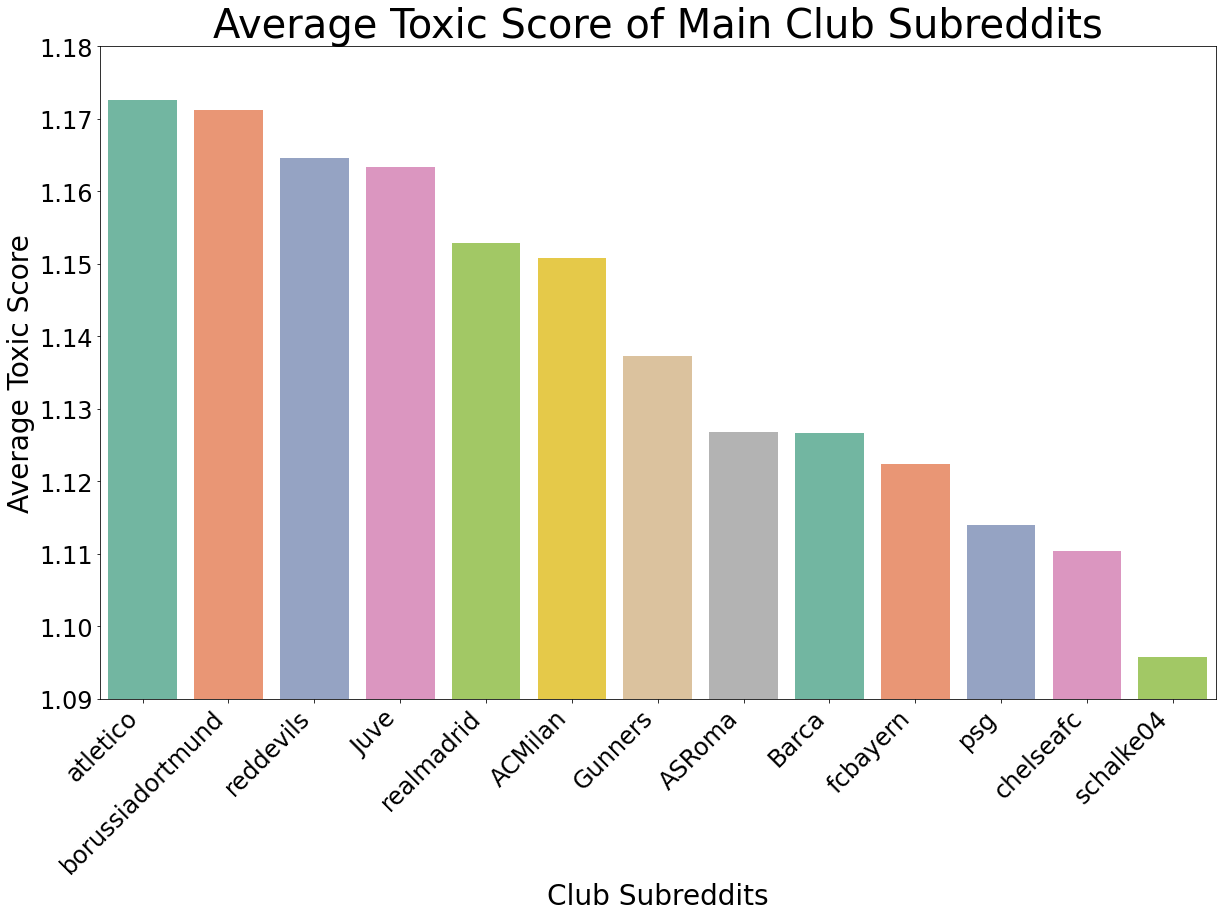

In [5]:
result_avg = result.groupBy('subreddit').agg(F.avg('toxic_score').alias('average_toxic_score'))
result_pd = result_avg.toPandas()
result_pd.to_csv("toxic_club.csv")

club = pd.read_csv("Users/tl864/fall-2023-reddit-project-team-08/data/csv/toxic_club.csv")\
    .sort_values(by='average_toxic_score', ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x='subreddit', y='average_toxic_score', data=club, palette='Set2')
plt.title('Average Toxic Score of Main Club Subreddits', fontsize=40)
plt.xlabel('Club Subreddits', fontsize=28)
plt.ylabel('Average Toxic Score', fontsize=28)
plt.ylim(1.09, 1.18)
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis='both', labelsize=24)
plt.show()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 43, 11, Finished, Available)

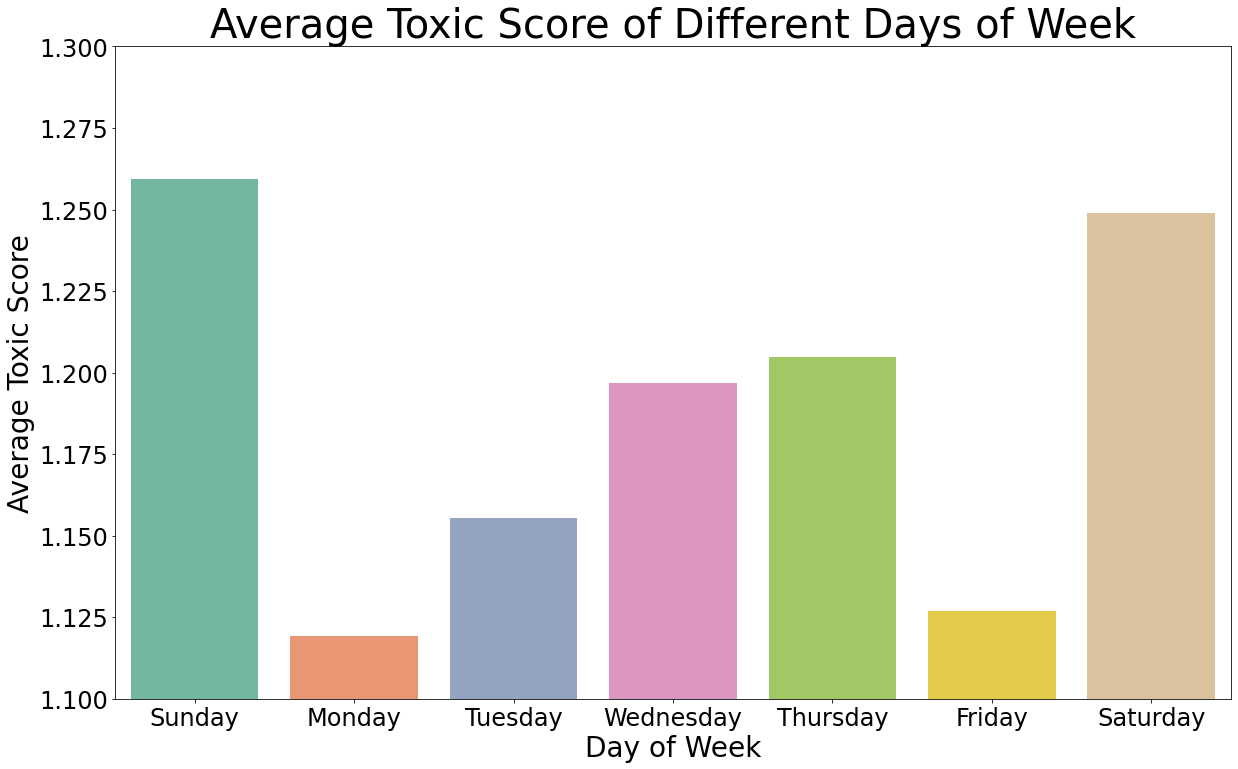

In [6]:
result_week = result.withColumn("day_of_week", F.dayofweek("created_utc")).groupBy('day_of_week')\
    .agg(F.avg('toxic_score').alias('average_toxic_score')).orderBy("day_of_week")
week_pd = result_week.toPandas()
week_pd.to_csv("toxic_week.csv")

week = pd.read_csv("Users/tl864/fall-2023-reddit-project-team-08/data/csv/toxic_week.csv")
days = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 
    7: "Saturday"}
week['day_of_week'] = week['day_of_week'].map(days)

plt.figure(figsize=(20, 12))
sns.barplot(x='day_of_week', y='average_toxic_score', data=week, palette='Set2')
plt.title('Average Toxic Score of Different Days of Week', fontsize=40)
plt.xlabel('Day of Week', fontsize=28)
plt.ylabel('Average Toxic Score', fontsize=28)
plt.ylim(1.1, 1.3)
plt.tick_params(axis='both', labelsize=24)
plt.show()

In [22]:
result_date = result.withColumn("date", F.date_trunc("day", "created_utc"))\
    .groupBy('date').agg(F.avg('toxic_score').alias('average_toxic_score')).orderBy("date")
date_pd = result_date.toPandas()
date_pd.to_csv("toxic_date.csv")

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 39, 24, Finished, Available)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 48, 10, Finished, Available)

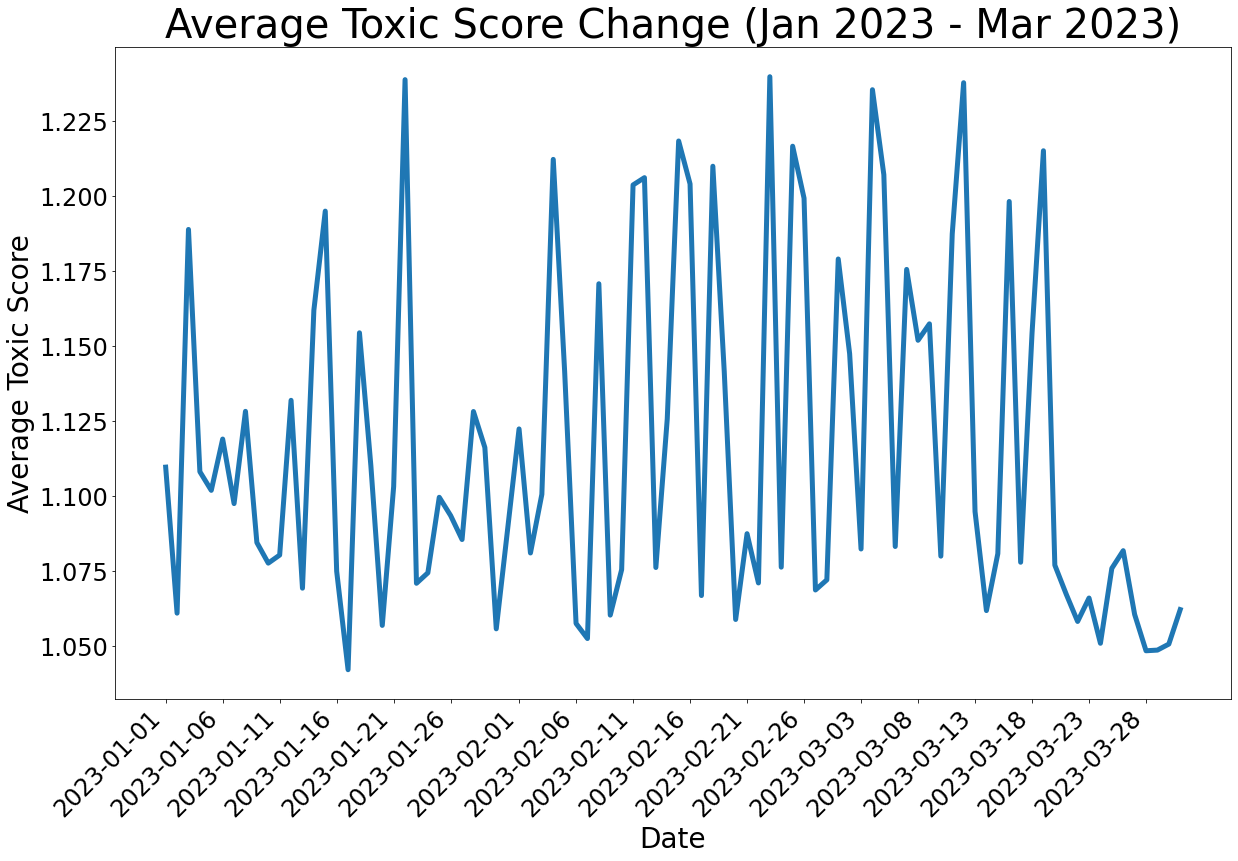

In [5]:
date = pd.read_csv("Users/tl864/fall-2023-reddit-project-team-08/data/csv/toxic_date.csv")
date['date'] = pd.to_datetime(date['date'])

plt.figure(figsize=(20, 12))
sns.lineplot(x='date', y='average_toxic_score', data=date, palette='Set2', linewidth=5)
plt.title('Average Toxic Score Change (Jan 2023 - Mar 2023)', fontsize=40)
plt.xlabel('Date', fontsize=28)
plt.ylabel('Average Toxic Score', fontsize=28)
plt.xticks(date['date'][::5], date['date'].dt.strftime('%Y-%m-%d')[::5], rotation=45, ha="right")
plt.tick_params(axis='both', labelsize=24)
plt.show()

According to the classification result, the first tabel reveals varying levels of toxicity in comments across soccer club subreddits, with atletico's subreddit showing the highest average toxicity score (1.172) and schalke04's the lowest (1.095). It is understandable the Atletico has the highest toxicity score since the it is widely known as one of the most violent clubs in Europe. We also found that different days of week have different level of toxicity score. On weekends, the toxic comments are more than weekdays since league games are played on weekends so people tend to have hostile comments during and after games. It is noticeable that the scores on Wednesday and Thursday is also relatively higher because UEFA Champions League and Europa League played on these days. According to the lineplot, the weekly periodic pattern is obvious, which has been proved by the table of toxicity score for different days of week. Instead of club games, national team games were held from March 20 to March 28 so the toxicity is fairly low during this time.